# 2D Acoustic Wave Equation
---

Consider the 2d acoustic wave equation
$$
\begin{aligned}
&\frac{\partial^2 p}{\partial t^2} = c^2(x, z)\left(\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial z^2}\right) + \frac{\partial}{\partial t}f(x, z, t) \\
\end{aligned}
$$
where $p$ is Pressure, $c$ is Medium Velocity. The source term $f$ is represented by a Ricker wavelet (practically, we regard it as a multiplication of Ricker wavelet in temporal domain with Gaussian dissolve in the spatial domain)
$$
f(x, z, t) = R(t)N(x, z),
$$
where
$$
R(t) = \left(1-2(\pi f_0(t-t_0))^2\right)\exp\left(-(\pi f_0(t-t_0))^2\right),
$$
where $f_0 = 20$ is the dominant frequency, $t_0 = 0.05$ is time delay, and
$$
N(x, z) = \exp\left(-\frac{1}{\alpha^2}\left((x-x_s)^2+(z-z_s)^2\right)\right).
$$

---

**We need to notice that there is a $\frac{\partial}{\partial t}$ in this second-order equation. This comes from converting the first-order equation to second-order**.

Hence, 
$$
\frac{\partial}{\partial t}f(x, z, t) = -2A^2(t-t_0)(3-2A^2(t-t_0)^2)e^{-A^2(t-t_0)^2},
$$
where $A = \pi f_0$.

---

## Data

- $p$: Pressure

- All known data are collected in the spatial domain $(x, z) \in [1, 500]\times [1, 500]$, with grid size 10 (which means the spatial grids are {10, 20, ..., 500}. The temporal domain is $t\in [0, 0.5)$, with time step $dt = 0.01$. This gives 50 time steps as recorded, i.e., $t = \{0, 0.01, \cdots, 0.49\}$.

- The sources are located at $(x_s, z_s) = \{50, 100, \cdots, 450\} \times \{10\}$.

## Target
- Recover the direct problem $p$
- Recover the inverse problem $c$

## Scaling (A simple substitution of variables)

We let
$$
x' = \frac{x}{x_0}, \ z' = \frac{z}{z_0}, \ t' = \frac{t}{t_0}, \ u' = \frac{u}{u_0}, \ c' = \frac{c}{c_0},
$$
where $x_0, z_0, t_0, u_0, c_0$ are scaling constants to be determined. Then the equation becomes
$$
\frac{p_0}{t_0^2}\frac{\partial^2 p'}{\partial t'^2} = c_0^2c'(x_0x', z_0z')\left(\frac{p_0}{x_0^2}\frac{\partial^2 p'}{\partial x'^2} + \frac{p_0}{z_0^2}\frac{\partial^2 p'}{\partial z'^2}\right) + f(x_0x', z_0z', t_0t').
$$

In this case, we let
$$
x_0 = z_0 = c_0 = 1000, \ t_0 = 1, \ p_0 = 1,
$$

---

## Initialize inverse model:

- add bias (close to true value) to the last layer of inverse model

---

## Simplify the problem

We first consider $c(x, z)$ is independent of $x$, i.e,  $c(x, z) = c(z)$.

---

## Pretrain the direct model

We pretrain the direct model with $c'(x, z) \equiv 1.0$.

In [1]:
NAME = "0705_pretrain_direct_model"

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

In [3]:
def setup_model(layers, c, w0, lambda_1, adaptive = None):
	class scaled_dense(keras.layers.Layer):
		def __init__(self, units, input_dim, c, w0, lambda_1):
			super(scaled_dense, self).__init__()
			self.lambda_1 = lambda_1
			w_init = tf.random_uniform_initializer(-np.sqrt(c/input_dim), np.sqrt(c/input_dim))
			self.w = tf.Variable(initial_value = w_init(shape = (input_dim, units), dtype = "float32"), trainable = True)
			b_init = tf.zeros_initializer()
			self.b = tf.Variable(initial_value = b_init(shape=(units,), dtype="float32"), trainable=True)
			self.w0 = tf.Variable(w0, dtype = "float32", trainable = True)
			
		def call(self, inputs):
			self.add_loss(self.lambda_1*tf.reduce_sum(tf.abs(self.w)))
			return tf.sin(tf.matmul(inputs, self.w)*self.w0 + self.b)
	
	with tf.device("/device:GPU:0"):
		model = keras.models.Sequential()
		if adaptive == "first" or adaptive == "all":
			model.add(scaled_dense(layers[1], layers[0], c, w0, lambda_1))
		else:
			model.add(keras.layers.Dense(layers[1], input_shape = (layers[0], ), activation = K.sin,
										kernel_initializer = keras.initializers.RandomUniform(-w0*np.sqrt(c/layers[0]), w0*np.sqrt(c/layers[0])),
										kernel_regularizer = keras.regularizers.l1(lambda_1)))
		for i in range(1, len(layers)-2):
			if adaptive == "all":
				model.add(scaled_dense(layers[i+1], layers[i], c, 1.0, lambda_1))
			else:
				model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = K.sin,
									kernel_initializer = keras.initializers.RandomUniform(-np.sqrt(c/layers[i]), np.sqrt(c/layers[i])),
									kernel_regularizer = keras.regularizers.l1(lambda_1)))
		model.add(keras.layers.Dense(layers[-1]))
	return model

def generate_model(layers, adaptive = None, bias = None):
	class adaptive_dense(keras.layers.Layer):
		def __init__(self, units, input_dim):
			super(adaptive_dense, self).__init__()
			w_init = keras.initializers.GlorotUniform()
			self.w = tf.Variable(initial_value = w_init(shape = (input_dim, units), dtype = "float32"), trainable = True)
			b_init = tf.zeros_initializer()
			self.b = tf.Variable(initial_value = b_init(shape=(units,), dtype="float32"), trainable=True)
			self.a = tf.Variable(1.0, dtype = "float32", trainable = True)
			
		def call(self, inputs):
			return tf.tanh(self.a*(tf.matmul(inputs, self.w) + self.b))
	
	with tf.device("/device:GPU:0"):
		model = keras.models.Sequential()
		if adaptive == "first" or adaptive == "all":
			model.add(adaptive_dense(layers[1], layers[0]))
		else:
			model.add(keras.layers.Dense(layers[1], input_shape = (layers[0], ), activation = "tanh"))
		for i in range(1, len(layers)-2):
			if adaptive == "all":
				model.add(adaptive_dense(layers[i+1], layers[i]))
			else:
				model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = "tanh"))
		if bias:
			model.add(keras.layers.Dense(layers[-1], bias_initializer = keras.initializers.Constant(bias)))
		else:
			model.add(keras.layers.Dense(layers[-1]))
	return model

w0 = 100
c = 6
lambda_1 = 0.5

direct_layers = [4, 128, 128, 128, 128, 1] # (x, z, t, xs) -> p
direct_model = setup_model(direct_layers, c, w0, lambda_1)

# inverse_layers = [1, 32, 32, 1] # (z) -> (c)
# inverse_bias = 2.0
# inverse_model = generate_model(inverse_layers, True, inverse_bias)

In [9]:
x0, z0, t0 = 1e3, 1e3, 1.0
p0, c0 = 1.0, 1e3
c = 1.0 # prior knowledge

In [10]:
# source
f_0 = 20.0
A = f_0*np.pi
alpha = 2.0*10 # multiplied by dx
M0 = 1 # scale p

# actually, it's dR/dt
@tf.function
def R(t, t_s):
	return M0*(-2*A**2)*(t-t_s)*(3-2*(A*(t-t_s))**2)*tf.exp(-(A*(t-t_s))**2)

@tf.function
def N(x, z, x_s, z_s):
	return tf.exp(-1.0/(alpha**2) * ((x-x_s)**2 + (z-z_s)**2))

# actually, it's df/dt
@tf.function
def f(x, z, t, x_s, z_s, t_s):
	return R(t, t_s)*N(x, z, x_s, z_s)

In [6]:
w_zero = 1e-2
threshold = 1e-3

def weighted_loss(true, pred):
	error = K.square(true - pred)
	error = K.mean(K.switch(K.less_equal(K.abs(true), threshold), w_zero * error , error))
	return error 

In [26]:
loss_func = keras.losses.MeanSquaredError()
loss_func_r = keras.losses.MeanAbsoluteError() # l1 loss

def get_residue_loss(tape, p, x, z, t, x_s, z_s, t_s):
	dp_dt = tape.gradient(p, t)
	dp_dtt = tape.gradient(dp_dt, t)
	dp_dx = tape.gradient(p, x)
	dp_dxx = tape.gradient(dp_dx, x)
	dp_dz = tape.gradient(p, z)
	dp_dzz = tape.gradient(dp_dz, z)
	eq1 = loss_func_r(p0/(t0**2)*dp_dtt, c0**2*tf.square(c)*(p0/(x0**2)*dp_dxx + p0/(z0**2)*dp_dzz) + f(x0*x, z0*z, t0*t, x0*x_s, z0*z_s, t0*t_s))
	return eq1

def step(data_sources, residue = True):
	losses = []
	with tf.GradientTape(persistent = True) as tape:
		tape.watch([x for d in data_sources for x in d])
		for data in data_sources:
			[x_c, z_c, t_c, x_s_c, z_s_c, t_s_c,
			 x_i, z_i, t_i, p_i, x_s_i, z_s_i, t_s_i] = data
			out_c = direct_model(tf.concat([x_c, z_c, t_c, x_s_c], axis = 1))
			out_i = direct_model(tf.concat([x_i, z_i, t_i, x_s_i], axis = 1))

			loss_c = get_residue_loss(tape, out_c, x_c, z_c, t_c, x_s_c, z_s_c, t_s_c)
			loss_ir = get_residue_loss(tape, out_i, x_i, z_i, t_i, x_s_i, z_s_i, t_s_i)
			loss_iv = loss_func(out_i, p_i)
			losses.append([loss_c, loss_ir, loss_iv])

		loss_c = sum([l[0] for l in losses])
		loss_ir = sum([l[1] for l in losses])
		loss_iv = sum([l[2] for l in losses])
		loss = w_c*loss_c + w_ir*loss_ir + w_iv*loss_iv
	
	grads_direct = tape.gradient(loss, direct_model.trainable_variables)
	optimizer_direct.apply_gradients(zip(grads_direct, direct_model.trainable_variables))
	
	del tape
	return loss, loss_c, loss_ir, loss_iv


def train(residue, data_sources, epochs, batch_proportion = 0.1, print_every = 100, save_every = 10000, save_path = None):
	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).shuffle(buffer_size = max(d[0].shape[0], 1), \
                                                        reshuffle_each_iteration = True).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
                                        for d in dataset]
	
	data_s = shuffled([d for d_s in data_sources for d in d_s])
	for epoch in range(1, epochs+1):
		losses = np.zeros((4,))
		for d in zip(*data_s): # d: [d_1_c, d_1_i, d_1_d, d_2_c, ...]
			data_sources = [list(d[i*2])+list(d[i*2+1]) for i in range(n_sources)]
			loss = step(data_sources, residue)
			losses += np.array(loss)
		losses *= batch_proportion
		
		if epoch % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}, c: {:.4e}, ir: {:.4e}, iv: {:.4e}".format(get_time(), epoch, *list(losses)))
		if epoch % save_every == 0:
			direct_model.save("models/{}/{}/direct_model".format(NAME, save_path))			

In [27]:
from scipy.io import loadmat

x_s = np.linspace(50.0, 450.0, 9) / x0
z_s = 10.0 / z0
t_s = 0.05 / t0
n_sources = len(x_s)

domain = [0, 500]
T_max = 0.5
dx = 10
dt = 0.01

In [28]:
# x_d = np.linspace(10.0, 500.0, 50) / x0
# z_d = np.array([10.0]) / z0
# t_d = np.linspace(0.0, 0.49, 50) / t0

# n_c = 1000
# x_c = transform(np.random.random((n_c, 1)), *domain) / x0
# z_c = transform(np.random.random((n_c, 1)), *domain) / z0
# t_c = transform(np.random.random((n_c, 1)), 0, T_max) / t0

# n_s = 100
# x_c_source = np.vstack([transform(np.random.random((n_s, 1)), xi-dx, xi+dx) for xi in x_s]) / x0
# z_c_source = np.vstack([transform(np.random.random((n_s, 1)), z_s-dx, z_s+dx) for i in x_s]) / z0
# t_c_source = np.vstack([transform(np.random.random((n_s, 1)), t_s-dt, t_s+dt) for i in x_s]) / t0

# x_c = np.vstack([x_c, x_c_source]) / x0
# z_c = np.vstack([z_c, z_c_source]) / z0
# t_c = np.vstack([t_c, t_c_source]) / t0

# n_i = 2000
# x_i = transform(np.random.random((n_i, 1)), *domain) / x0
# z_i = transform(np.random.random((n_i, 1)), *domain) / z0
# t_i = np.zeros_like(x_i) / t0
# p_i = np.zeros_like(x_i) / p0

# # txz_c = tensor_grid([t_c, x_c, z_c])
# txz_d = tensor_grid([t_d, x_d, z_d])

# map_to_tf_float32 = lambda x: list(map(lambda y: tf.constant(y, dtype = tf.float32), x))

# data_sources = []
# for x in x_s:
# 	p = loadmat("data/sr_{}.mat".format(int(x*x0/dx)))["sr_{}".format(int(x*x0/dx))].reshape((-1, 1)) / p0
# 	d_i = map_to_tf_float32([x_i, z_i, t_i, p_i, x*np.ones_like(x_i), z_s*np.ones_like(z_i), t_s*np.ones_like(t_i)])
# 	d_c = map_to_tf_float32([x_c, z_c, t_c, x*np.ones_like(x_c), z_s*np.ones_like(z_c), t_s*np.ones_like(t_c)])
# 	d_d = map_to_tf_float32([txz_d[:, 1:2], txz_d[:, 2:3], txz_d[:, 0:1], p, x*np.ones_like(txz_d[:, 1:2]), z_s*np.ones_like(txz_d[:, 2:3]), t_s*np.ones_like(txz_d[:, 0:1])])
# 	data_sources.append([d_c, d_i, d_d])

In [29]:
# from six.moves import cPickle as pickle

# with open("dataset_{}.pkl".format(NAME), "wb") as f:
# 	pickle.dump(data_sources, f)

In [30]:
from six.moves import cPickle as pickle

NAME_1 = "0630_0704_1_direct_model_siren_weighted_loss"
with open("dataset_{}.pkl".format(NAME_1), "rb") as file:
	data_sources = pickle.load(file)
data_sources = [d[:2] for d in data_sources]

In [32]:
i = 1
optimizer_direct = keras.optimizers.Adam(lr = 1e-3)

w_c = 1.0
w_ir = 1.0
w_iv = 1.0

train(False, data_sources, 10000, batch_proportion = 1.0, print_every = 10, save_every = 500, save_path = "{}_adam".format(i))

2020/07/05, 13:09:52, Epoch: 10, Loss: 8.4530e+04, c: 2.0651e+04, ir: 6.3878e+04, iv: 2.7426e-01
2020/07/05, 13:10:14, Epoch: 20, Loss: 6.3274e+04, c: 1.1495e+04, ir: 5.1779e+04, iv: 1.9725e-01
2020/07/05, 13:10:37, Epoch: 30, Loss: 5.0548e+04, c: 7.5852e+03, ir: 4.2962e+04, iv: 1.4494e-01
2020/07/05, 13:11:00, Epoch: 40, Loss: 4.2335e+04, c: 5.9903e+03, ir: 3.6345e+04, iv: 1.1270e-01
2020/07/05, 13:11:22, Epoch: 50, Loss: 3.6191e+04, c: 4.9990e+03, ir: 3.1192e+04, iv: 9.0478e-02
2020/07/05, 13:11:44, Epoch: 60, Loss: 3.1258e+04, c: 4.1357e+03, ir: 2.7122e+04, iv: 7.5054e-02
2020/07/05, 13:12:06, Epoch: 70, Loss: 2.7662e+04, c: 3.8157e+03, ir: 2.3847e+04, iv: 6.1953e-02
2020/07/05, 13:14:21, Epoch: 130, Loss: 1.4929e+04, c: 2.0138e+03, ir: 1.2915e+04, iv: 2.7717e-02
2020/07/05, 13:14:44, Epoch: 140, Loss: 1.4093e+04, c: 2.1881e+03, ir: 1.1905e+04, iv: 2.4907e-02
2020/07/05, 13:15:05, Epoch: 150, Loss: 1.2845e+04, c: 1.8686e+03, ir: 1.0976e+04, iv: 2.2842e-02
2020/07/05, 13:15:28, Epoch

2020/07/05, 13:41:51, Epoch: 860, Loss: 1.3067e+03, c: 3.8185e+02, ir: 9.2486e+02, iv: 1.0494e-03
2020/07/05, 13:42:15, Epoch: 870, Loss: 1.3690e+03, c: 4.4145e+02, ir: 9.2751e+02, iv: 1.0389e-03
2020/07/05, 13:42:38, Epoch: 880, Loss: 1.3541e+03, c: 4.3930e+02, ir: 9.1484e+02, iv: 9.8335e-04
2020/07/05, 13:43:01, Epoch: 890, Loss: 1.3331e+03, c: 4.1697e+02, ir: 9.1612e+02, iv: 1.0035e-03
2020/07/05, 13:43:24, Epoch: 900, Loss: 1.3177e+03, c: 4.4857e+02, ir: 8.6911e+02, iv: 9.7717e-04
2020/07/05, 13:43:47, Epoch: 910, Loss: 1.3224e+03, c: 4.5088e+02, ir: 8.7153e+02, iv: 9.6021e-04
2020/07/05, 13:44:10, Epoch: 920, Loss: 1.2865e+03, c: 4.3479e+02, ir: 8.5174e+02, iv: 9.0358e-04
2020/07/05, 13:44:32, Epoch: 930, Loss: 1.1928e+03, c: 3.8082e+02, ir: 8.1194e+02, iv: 9.0585e-04
2020/07/05, 13:44:54, Epoch: 940, Loss: 1.1776e+03, c: 3.7721e+02, ir: 8.0038e+02, iv: 8.5964e-04
2020/07/05, 13:45:17, Epoch: 950, Loss: 1.2741e+03, c: 4.5932e+02, ir: 8.1473e+02, iv: 8.7164e-04
2020/07/05, 13:45:40

2020/07/05, 14:15:11, Epoch: 1740, Loss: 5.5986e+02, c: 2.4586e+02, ir: 3.1401e+02, iv: 2.4372e-04
2020/07/05, 14:15:34, Epoch: 1750, Loss: 6.1301e+02, c: 2.8504e+02, ir: 3.2797e+02, iv: 2.5781e-04
2020/07/05, 14:15:57, Epoch: 1760, Loss: 6.8664e+02, c: 3.0926e+02, ir: 3.7738e+02, iv: 2.7181e-04
2020/07/05, 14:16:19, Epoch: 1770, Loss: 5.1386e+02, c: 2.2576e+02, ir: 2.8810e+02, iv: 2.3307e-04
2020/07/05, 14:16:42, Epoch: 1780, Loss: 5.5320e+02, c: 2.3610e+02, ir: 3.1710e+02, iv: 2.5204e-04
2020/07/05, 14:17:05, Epoch: 1790, Loss: 5.4823e+02, c: 2.4628e+02, ir: 3.0195e+02, iv: 2.3205e-04
2020/07/05, 14:17:28, Epoch: 1800, Loss: 6.3503e+02, c: 3.0046e+02, ir: 3.3457e+02, iv: 2.4758e-04
2020/07/05, 14:17:51, Epoch: 1810, Loss: 5.5502e+02, c: 2.6031e+02, ir: 2.9471e+02, iv: 2.3943e-04
2020/07/05, 14:18:13, Epoch: 1820, Loss: 4.8343e+02, c: 2.0070e+02, ir: 2.8273e+02, iv: 2.2583e-04
2020/07/05, 14:18:35, Epoch: 1830, Loss: 4.7012e+02, c: 2.0288e+02, ir: 2.6724e+02, iv: 2.2201e-04
2020/07/05

2020/07/05, 14:46:57, Epoch: 2590, Loss: 3.9372e+02, c: 1.8056e+02, ir: 2.1316e+02, iv: 1.0668e-04
2020/07/05, 14:47:21, Epoch: 2600, Loss: 3.0832e+02, c: 1.3862e+02, ir: 1.6969e+02, iv: 9.4997e-05
2020/07/05, 14:47:43, Epoch: 2610, Loss: 3.2169e+02, c: 1.4111e+02, ir: 1.8058e+02, iv: 1.0121e-04
2020/07/05, 14:48:06, Epoch: 2620, Loss: 2.6505e+02, c: 1.2141e+02, ir: 1.4364e+02, iv: 9.1660e-05
2020/07/05, 14:48:28, Epoch: 2630, Loss: 2.8350e+02, c: 1.2928e+02, ir: 1.5422e+02, iv: 9.3778e-05
2020/07/05, 14:48:51, Epoch: 2640, Loss: 2.7870e+02, c: 1.2020e+02, ir: 1.5850e+02, iv: 9.5548e-05
2020/07/05, 14:49:13, Epoch: 2650, Loss: 3.6765e+02, c: 1.7023e+02, ir: 1.9742e+02, iv: 1.0458e-04
2020/07/05, 14:49:35, Epoch: 2660, Loss: 3.2895e+02, c: 1.5325e+02, ir: 1.7570e+02, iv: 8.9510e-05
2020/07/05, 14:49:58, Epoch: 2670, Loss: 3.1282e+02, c: 1.4151e+02, ir: 1.7131e+02, iv: 9.8278e-05
2020/07/05, 14:50:21, Epoch: 2680, Loss: 3.3137e+02, c: 1.5033e+02, ir: 1.8104e+02, iv: 9.3797e-05
2020/07/05

2020/07/05, 15:19:47, Epoch: 3460, Loss: 2.2901e+02, c: 1.0279e+02, ir: 1.2622e+02, iv: 4.6296e-05
2020/07/05, 15:20:09, Epoch: 3470, Loss: 2.8001e+02, c: 1.3557e+02, ir: 1.4444e+02, iv: 4.3700e-05
2020/07/05, 15:20:32, Epoch: 3480, Loss: 2.2369e+02, c: 1.0180e+02, ir: 1.2189e+02, iv: 4.2096e-05
2020/07/05, 15:20:54, Epoch: 3490, Loss: 2.3074e+02, c: 1.0499e+02, ir: 1.2576e+02, iv: 4.3396e-05
2020/07/05, 15:21:17, Epoch: 3500, Loss: 2.1158e+02, c: 9.9997e+01, ir: 1.1158e+02, iv: 4.1623e-05
INFO:tensorflow:Assets written to: models/0705_pretrain_direct_model/1_adam/direct_model/assets
2020/07/05, 15:21:39, Epoch: 3510, Loss: 2.5442e+02, c: 1.2180e+02, ir: 1.3261e+02, iv: 4.4612e-05
2020/07/05, 15:22:02, Epoch: 3520, Loss: 2.7265e+02, c: 1.2557e+02, ir: 1.4709e+02, iv: 4.4628e-05
2020/07/05, 15:22:25, Epoch: 3530, Loss: 2.4383e+02, c: 1.1425e+02, ir: 1.2958e+02, iv: 4.1307e-05
2020/07/05, 15:22:47, Epoch: 3540, Loss: 2.2655e+02, c: 1.0425e+02, ir: 1.2230e+02, iv: 4.1627e-05
2020/07/05, 1

2020/07/05, 15:49:40, Epoch: 4340, Loss: 1.9242e+02, c: 8.0682e+01, ir: 1.1174e+02, iv: 2.0938e-05
2020/07/05, 15:50:03, Epoch: 4350, Loss: 2.0762e+02, c: 9.0474e+01, ir: 1.1715e+02, iv: 2.2218e-05
2020/07/05, 15:50:26, Epoch: 4360, Loss: 1.8400e+02, c: 7.7585e+01, ir: 1.0642e+02, iv: 2.1069e-05
2020/07/05, 15:50:49, Epoch: 4370, Loss: 1.5151e+02, c: 6.8244e+01, ir: 8.3261e+01, iv: 1.7942e-05
2020/07/05, 15:51:13, Epoch: 4380, Loss: 1.5594e+02, c: 7.1388e+01, ir: 8.4555e+01, iv: 1.7051e-05
2020/07/05, 15:51:35, Epoch: 4390, Loss: 1.6302e+02, c: 7.4105e+01, ir: 8.8911e+01, iv: 1.9383e-05
2020/07/05, 15:51:58, Epoch: 4400, Loss: 1.6756e+02, c: 7.6376e+01, ir: 9.1180e+01, iv: 1.9229e-05
2020/07/05, 15:52:20, Epoch: 4410, Loss: 1.7527e+02, c: 7.4440e+01, ir: 1.0083e+02, iv: 2.2386e-05
2020/07/05, 15:52:42, Epoch: 4420, Loss: 1.9382e+02, c: 8.2828e+01, ir: 1.1099e+02, iv: 1.9935e-05
2020/07/05, 15:53:04, Epoch: 4430, Loss: 1.7198e+02, c: 7.7402e+01, ir: 9.4583e+01, iv: 1.7384e-05
2020/07/05

2020/07/05, 16:22:11, Epoch: 5200, Loss: 1.0096e+02, c: 4.0512e+01, ir: 6.0448e+01, iv: 8.0464e-06
2020/07/05, 16:22:34, Epoch: 5210, Loss: 1.0647e+02, c: 4.6168e+01, ir: 6.0301e+01, iv: 8.3445e-06
2020/07/05, 16:22:57, Epoch: 5220, Loss: 9.9301e+01, c: 4.1605e+01, ir: 5.7697e+01, iv: 7.7455e-06
2020/07/05, 16:24:50, Epoch: 5270, Loss: 1.2272e+02, c: 5.2737e+01, ir: 6.9987e+01, iv: 1.0104e-05
2020/07/05, 16:25:13, Epoch: 5280, Loss: 9.1238e+01, c: 4.0173e+01, ir: 5.1065e+01, iv: 6.8289e-06
2020/07/05, 16:25:36, Epoch: 5290, Loss: 1.1518e+02, c: 4.9291e+01, ir: 6.5889e+01, iv: 8.5359e-06
2020/07/05, 16:25:58, Epoch: 5300, Loss: 1.5538e+02, c: 6.7069e+01, ir: 8.8312e+01, iv: 1.1936e-05
2020/07/05, 16:26:20, Epoch: 5310, Loss: 1.2377e+02, c: 5.2851e+01, ir: 7.0916e+01, iv: 7.5239e-06
2020/07/05, 16:26:43, Epoch: 5320, Loss: 1.3518e+02, c: 6.3825e+01, ir: 7.1354e+01, iv: 9.0061e-06
2020/07/05, 16:27:05, Epoch: 5330, Loss: 1.6183e+02, c: 6.9706e+01, ir: 9.2121e+01, iv: 1.0058e-05
2020/07/05

2020/07/05, 16:54:16, Epoch: 6050, Loss: 6.3027e+01, c: 2.5954e+01, ir: 3.7074e+01, iv: 2.9713e-06
2020/07/05, 16:54:40, Epoch: 6060, Loss: 8.1255e+01, c: 3.3214e+01, ir: 4.8041e+01, iv: 3.9183e-06
2020/07/05, 16:55:03, Epoch: 6070, Loss: 6.8369e+01, c: 2.7206e+01, ir: 4.1164e+01, iv: 3.0390e-06
2020/07/05, 16:55:25, Epoch: 6080, Loss: 6.7456e+01, c: 2.6460e+01, ir: 4.0997e+01, iv: 3.2554e-06
2020/07/05, 16:55:47, Epoch: 6090, Loss: 7.3370e+01, c: 3.0614e+01, ir: 4.2756e+01, iv: 3.0491e-06
2020/07/05, 16:56:10, Epoch: 6100, Loss: 6.7364e+01, c: 2.7561e+01, ir: 3.9803e+01, iv: 3.0805e-06
2020/07/05, 16:56:32, Epoch: 6110, Loss: 7.0434e+01, c: 2.8450e+01, ir: 4.1983e+01, iv: 3.0529e-06
2020/07/05, 16:56:54, Epoch: 6120, Loss: 8.8670e+01, c: 3.8412e+01, ir: 5.0259e+01, iv: 3.7547e-06
2020/07/05, 16:57:16, Epoch: 6130, Loss: 7.4749e+01, c: 3.2240e+01, ir: 4.2509e+01, iv: 2.9171e-06
2020/07/05, 16:57:38, Epoch: 6140, Loss: 8.3366e+01, c: 3.4069e+01, ir: 4.9297e+01, iv: 3.1223e-06
2020/07/05

2020/07/05, 17:20:51, Epoch: 6930, Loss: 4.9993e+01, c: 1.9817e+01, ir: 3.0176e+01, iv: 1.2437e-06
2020/07/05, 17:21:08, Epoch: 6940, Loss: 4.8409e+01, c: 1.9896e+01, ir: 2.8513e+01, iv: 1.1728e-06
2020/07/05, 17:21:26, Epoch: 6950, Loss: 5.8648e+01, c: 2.3952e+01, ir: 3.4696e+01, iv: 1.4761e-06
2020/07/05, 17:21:43, Epoch: 6960, Loss: 5.6932e+01, c: 2.2882e+01, ir: 3.4050e+01, iv: 1.6738e-06
2020/07/05, 17:22:00, Epoch: 6970, Loss: 4.8064e+01, c: 1.9495e+01, ir: 2.8569e+01, iv: 1.0413e-06
2020/07/05, 17:22:18, Epoch: 6980, Loss: 3.9601e+01, c: 1.5923e+01, ir: 2.3678e+01, iv: 1.0224e-06
2020/07/05, 17:22:35, Epoch: 6990, Loss: 4.8206e+01, c: 1.9229e+01, ir: 2.8977e+01, iv: 1.1425e-06
2020/07/05, 17:22:53, Epoch: 7000, Loss: 5.2795e+01, c: 2.2253e+01, ir: 3.0542e+01, iv: 1.4493e-06
INFO:tensorflow:Assets written to: models/0705_pretrain_direct_model/1_adam/direct_model/assets
2020/07/05, 17:23:11, Epoch: 7010, Loss: 4.6785e+01, c: 1.9047e+01, ir: 2.7738e+01, iv: 1.0651e-06
2020/07/05, 1

2020/07/05, 17:46:25, Epoch: 7810, Loss: 4.4628e+01, c: 1.7056e+01, ir: 2.7572e+01, iv: 7.7741e-07
2020/07/05, 17:46:42, Epoch: 7820, Loss: 3.5054e+01, c: 1.3626e+01, ir: 2.1428e+01, iv: 5.5929e-07
2020/07/05, 17:46:59, Epoch: 7830, Loss: 4.3830e+01, c: 1.7461e+01, ir: 2.6369e+01, iv: 6.7500e-07
2020/07/05, 17:47:17, Epoch: 7840, Loss: 3.7873e+01, c: 1.4711e+01, ir: 2.3161e+01, iv: 6.2538e-07
2020/07/05, 17:47:34, Epoch: 7850, Loss: 4.7240e+01, c: 1.8212e+01, ir: 2.9028e+01, iv: 8.7413e-07
2020/07/05, 17:47:52, Epoch: 7860, Loss: 3.1930e+01, c: 1.2074e+01, ir: 1.9857e+01, iv: 5.2120e-07
2020/07/05, 17:48:09, Epoch: 7870, Loss: 3.7024e+01, c: 1.4723e+01, ir: 2.2302e+01, iv: 5.9102e-07
2020/07/05, 17:48:26, Epoch: 7880, Loss: 3.0738e+01, c: 1.1285e+01, ir: 1.9453e+01, iv: 5.6453e-07
2020/07/05, 17:48:44, Epoch: 7890, Loss: 3.1310e+01, c: 1.1404e+01, ir: 1.9906e+01, iv: 5.8676e-07
2020/07/05, 17:49:01, Epoch: 7900, Loss: 2.9129e+01, c: 1.0989e+01, ir: 1.8141e+01, iv: 4.5102e-07
2020/07/05

2020/07/05, 18:11:38, Epoch: 8680, Loss: 2.9911e+01, c: 1.0651e+01, ir: 1.9259e+01, iv: 4.6024e-07
2020/07/05, 18:11:55, Epoch: 8690, Loss: 2.2632e+01, c: 9.1386e+00, ir: 1.3493e+01, iv: 2.5595e-07
2020/07/05, 18:12:13, Epoch: 8700, Loss: 2.1107e+01, c: 8.0254e+00, ir: 1.3081e+01, iv: 2.0399e-07
2020/07/05, 18:12:30, Epoch: 8710, Loss: 1.8395e+01, c: 6.6372e+00, ir: 1.1757e+01, iv: 2.2730e-07
2020/07/05, 18:12:47, Epoch: 8720, Loss: 2.7868e+01, c: 1.0258e+01, ir: 1.7610e+01, iv: 6.3956e-07
2020/07/05, 18:13:05, Epoch: 8730, Loss: 2.3938e+01, c: 8.9845e+00, ir: 1.4953e+01, iv: 3.5019e-07
2020/07/05, 18:13:22, Epoch: 8740, Loss: 2.8174e+01, c: 1.0860e+01, ir: 1.7314e+01, iv: 3.7051e-07
2020/07/05, 18:13:40, Epoch: 8750, Loss: 1.7665e+01, c: 6.4587e+00, ir: 1.1206e+01, iv: 1.5060e-07
2020/07/05, 18:13:57, Epoch: 8760, Loss: 2.4205e+01, c: 8.7731e+00, ir: 1.5432e+01, iv: 2.7968e-07
2020/07/05, 18:14:15, Epoch: 8770, Loss: 2.5653e+01, c: 1.0016e+01, ir: 1.5636e+01, iv: 2.3432e-07
2020/07/05

2020/07/05, 18:36:35, Epoch: 9540, Loss: 1.4459e+01, c: 4.9238e+00, ir: 9.5356e+00, iv: 1.2396e-07
2020/07/05, 18:36:53, Epoch: 9550, Loss: 1.6082e+01, c: 5.8405e+00, ir: 1.0241e+01, iv: 1.2486e-07
2020/07/05, 18:37:10, Epoch: 9560, Loss: 1.3699e+01, c: 4.9057e+00, ir: 8.7930e+00, iv: 9.6750e-08
2020/07/05, 18:37:28, Epoch: 9570, Loss: 1.3791e+01, c: 4.9071e+00, ir: 8.8838e+00, iv: 7.5693e-08
2020/07/05, 18:37:46, Epoch: 9580, Loss: 2.0142e+01, c: 7.4305e+00, ir: 1.2712e+01, iv: 2.0920e-07
2020/07/05, 18:38:03, Epoch: 9590, Loss: 1.6125e+01, c: 6.1042e+00, ir: 1.0021e+01, iv: 1.3837e-07
2020/07/05, 18:38:20, Epoch: 9600, Loss: 1.3593e+01, c: 4.9620e+00, ir: 8.6310e+00, iv: 1.4717e-07
2020/07/05, 18:38:38, Epoch: 9610, Loss: 1.3625e+01, c: 4.7202e+00, ir: 8.9050e+00, iv: 8.1858e-08
2020/07/05, 18:38:55, Epoch: 9620, Loss: 1.4372e+01, c: 4.9710e+00, ir: 9.4009e+00, iv: 9.9307e-08
2020/07/05, 18:39:13, Epoch: 9630, Loss: 1.1627e+01, c: 4.2106e+00, ir: 7.4162e+00, iv: 9.9555e-08
2020/07/05

In [43]:
i = 2
optimizer_direct = keras.optimizers.Adam(learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay([5000.0, 10000.0, 15000.0, 20000.0], [5e-4, 2e-4, 1e-4, 5e-5, 2e-5]))

w_c = 1.0
w_ir = 1.0
w_iv = 1.0

train(False, data_sources, 30000, batch_proportion = 1.0, print_every = 10, save_every = 500, save_path = "{}_adam".format(i))

2020/07/06, 00:50:21, Epoch: 10, Loss: 2.3804e+01, c: 8.4056e+00, ir: 1.5399e+01, iv: 2.3325e-06
2020/07/06, 00:50:38, Epoch: 20, Loss: 1.7642e+01, c: 7.2462e+00, ir: 1.0396e+01, iv: 1.0261e-06
2020/07/06, 00:50:55, Epoch: 30, Loss: 8.9314e+00, c: 3.4316e+00, ir: 5.4998e+00, iv: 1.1341e-07
2020/07/06, 00:51:13, Epoch: 40, Loss: 7.0840e+00, c: 2.6085e+00, ir: 4.4755e+00, iv: 7.6787e-08
2020/07/06, 00:51:30, Epoch: 50, Loss: 6.1318e+00, c: 2.4188e+00, ir: 3.7130e+00, iv: 2.9145e-07
2020/07/06, 00:51:47, Epoch: 60, Loss: 5.0511e+00, c: 1.9294e+00, ir: 3.1218e+00, iv: 2.9487e-07
2020/07/06, 00:52:05, Epoch: 70, Loss: 5.3524e+00, c: 2.1027e+00, ir: 3.2497e+00, iv: 1.7997e-08
2020/07/06, 00:52:22, Epoch: 80, Loss: 3.6650e+00, c: 1.4068e+00, ir: 2.2583e+00, iv: 1.0769e-08
2020/07/06, 00:52:39, Epoch: 90, Loss: 3.2551e+00, c: 1.1240e+00, ir: 2.1311e+00, iv: 1.3009e-08
2020/07/06, 00:52:57, Epoch: 100, Loss: 3.8794e+00, c: 1.3611e+00, ir: 2.5182e+00, iv: 1.3846e-08
2020/07/06, 00:53:14, Epoch: 

2020/07/06, 01:14:24, Epoch: 840, Loss: 1.3576e+00, c: 5.3814e-01, ir: 8.1945e-01, iv: 6.6659e-08
2020/07/06, 01:14:41, Epoch: 850, Loss: 1.4361e+00, c: 5.7967e-01, ir: 8.5645e-01, iv: 5.6731e-09
2020/07/06, 01:14:59, Epoch: 860, Loss: 1.6613e+00, c: 5.8895e-01, ir: 1.0724e+00, iv: 2.9050e-08
2020/07/06, 01:15:16, Epoch: 870, Loss: 1.4485e+00, c: 5.3702e-01, ir: 9.1148e-01, iv: 2.7079e-08
2020/07/06, 01:15:33, Epoch: 880, Loss: 1.9006e+00, c: 8.5630e-01, ir: 1.0443e+00, iv: 3.6088e-08
2020/07/06, 01:15:51, Epoch: 890, Loss: 2.1699e+00, c: 8.8485e-01, ir: 1.2851e+00, iv: 1.3623e-08
2020/07/06, 01:16:08, Epoch: 900, Loss: 1.4168e+00, c: 5.5693e-01, ir: 8.5984e-01, iv: 7.6367e-08
2020/07/06, 01:16:25, Epoch: 910, Loss: 1.7763e+00, c: 6.3489e-01, ir: 1.1414e+00, iv: 5.9235e-09
2020/07/06, 01:16:42, Epoch: 920, Loss: 1.7559e+00, c: 6.9874e-01, ir: 1.0572e+00, iv: 4.1280e-08
2020/07/06, 01:17:00, Epoch: 930, Loss: 1.3149e+00, c: 4.6332e-01, ir: 8.5156e-01, iv: 1.2391e-08
2020/07/06, 01:17:18

2020/07/06, 01:37:49, Epoch: 1650, Loss: 3.0104e+00, c: 1.4825e+00, ir: 1.5278e+00, iv: 3.3262e-07
2020/07/06, 01:38:06, Epoch: 1660, Loss: 1.9507e+00, c: 9.0471e-01, ir: 1.0460e+00, iv: 6.9360e-06
2020/07/06, 01:38:24, Epoch: 1670, Loss: 2.2426e+00, c: 1.0186e+00, ir: 1.2239e+00, iv: 2.9706e-07
2020/07/06, 01:38:41, Epoch: 1680, Loss: 1.2237e+00, c: 5.3027e-01, ir: 6.9339e-01, iv: 1.3669e-06
2020/07/06, 01:38:58, Epoch: 1690, Loss: 1.7921e+00, c: 8.0688e-01, ir: 9.8517e-01, iv: 1.2529e-06
2020/07/06, 01:39:16, Epoch: 1700, Loss: 1.1510e+00, c: 5.0212e-01, ir: 6.4891e-01, iv: 3.6320e-07
2020/07/06, 01:39:33, Epoch: 1710, Loss: 7.1709e-01, c: 3.1066e-01, ir: 4.0643e-01, iv: 2.3735e-08
2020/07/06, 01:39:51, Epoch: 1720, Loss: 9.5937e-01, c: 4.2452e-01, ir: 5.3485e-01, iv: 1.0194e-07
2020/07/06, 01:40:08, Epoch: 1730, Loss: 5.6466e-01, c: 2.2640e-01, ir: 3.3826e-01, iv: 1.0307e-07
2020/07/06, 01:40:25, Epoch: 1740, Loss: 7.0993e-01, c: 3.1639e-01, ir: 3.9354e-01, iv: 2.3466e-08
2020/07/06

2020/07/06, 02:01:31, Epoch: 2470, Loss: 3.2686e-01, c: 1.2595e-01, ir: 2.0091e-01, iv: 6.1986e-07
2020/07/06, 02:01:49, Epoch: 2480, Loss: 4.0373e-01, c: 1.6075e-01, ir: 2.4297e-01, iv: 5.0662e-07
2020/07/06, 02:02:06, Epoch: 2490, Loss: 3.7331e-01, c: 1.3914e-01, ir: 2.3417e-01, iv: 5.5318e-08
2020/07/06, 02:02:23, Epoch: 2500, Loss: 6.8237e-01, c: 3.2053e-01, ir: 3.6185e-01, iv: 1.9482e-08
INFO:tensorflow:Assets written to: models/0705_pretrain_direct_model/2_adam/direct_model/assets
2020/07/06, 02:02:41, Epoch: 2510, Loss: 4.5682e-01, c: 1.9087e-01, ir: 2.6595e-01, iv: 5.1980e-08
2020/07/06, 02:02:59, Epoch: 2520, Loss: 8.6437e-01, c: 3.5844e-01, ir: 5.0593e-01, iv: 2.1167e-09
2020/07/06, 02:03:16, Epoch: 2530, Loss: 6.8963e-01, c: 3.0343e-01, ir: 3.8620e-01, iv: 1.6516e-07
2020/07/06, 02:03:34, Epoch: 2540, Loss: 7.6369e-01, c: 3.4956e-01, ir: 4.1414e-01, iv: 1.0230e-06
2020/07/06, 02:03:51, Epoch: 2550, Loss: 5.8910e-01, c: 2.5291e-01, ir: 3.3619e-01, iv: 1.2275e-07
2020/07/06, 0

2020/07/06, 02:25:00, Epoch: 3280, Loss: 1.6398e-01, c: 6.4764e-02, ir: 9.9215e-02, iv: 1.3129e-08
2020/07/06, 02:25:17, Epoch: 3290, Loss: 1.6325e-01, c: 6.7860e-02, ir: 9.5393e-02, iv: 2.8141e-09
2020/07/06, 02:25:35, Epoch: 3300, Loss: 1.5171e-01, c: 5.6215e-02, ir: 9.5494e-02, iv: 1.0554e-08
2020/07/06, 02:25:52, Epoch: 3310, Loss: 1.5114e-01, c: 5.6755e-02, ir: 9.4386e-02, iv: 1.5389e-07
2020/07/06, 02:26:09, Epoch: 3320, Loss: 1.7223e-01, c: 6.1761e-02, ir: 1.1047e-01, iv: 2.4140e-07
2020/07/06, 02:26:27, Epoch: 3330, Loss: 1.5089e-01, c: 5.3250e-02, ir: 9.7636e-02, iv: 9.1648e-10
2020/07/06, 02:26:44, Epoch: 3340, Loss: 1.6867e-01, c: 6.3539e-02, ir: 1.0514e-01, iv: 1.6929e-07
2020/07/06, 02:27:02, Epoch: 3350, Loss: 2.1746e-01, c: 9.5757e-02, ir: 1.2170e-01, iv: 2.8676e-08
2020/07/06, 02:27:19, Epoch: 3360, Loss: 1.5205e-01, c: 5.9801e-02, ir: 9.2248e-02, iv: 3.6450e-08
2020/07/06, 02:27:37, Epoch: 3370, Loss: 1.7519e-01, c: 7.0321e-02, ir: 1.0487e-01, iv: 1.7644e-07
2020/07/06

2020/07/06, 02:48:26, Epoch: 4090, Loss: 1.0266e-01, c: 3.4090e-02, ir: 6.8568e-02, iv: 1.9879e-07
2020/07/06, 02:48:43, Epoch: 4100, Loss: 8.4134e-02, c: 3.0387e-02, ir: 5.3747e-02, iv: 1.7973e-09
2020/07/06, 02:49:01, Epoch: 4110, Loss: 9.0390e-02, c: 3.1218e-02, ir: 5.9171e-02, iv: 3.4493e-08
2020/07/06, 02:49:18, Epoch: 4120, Loss: 7.1523e-02, c: 2.3991e-02, ir: 4.7532e-02, iv: 1.2168e-08
2020/07/06, 02:49:35, Epoch: 4130, Loss: 8.3881e-02, c: 2.6573e-02, ir: 5.7307e-02, iv: 2.8462e-08
2020/07/06, 02:49:53, Epoch: 4140, Loss: 8.2254e-02, c: 3.0479e-02, ir: 5.1775e-02, iv: 1.5917e-08
2020/07/06, 02:50:10, Epoch: 4150, Loss: 8.4237e-02, c: 2.8239e-02, ir: 5.5998e-02, iv: 2.1157e-08
2020/07/06, 02:50:27, Epoch: 4160, Loss: 9.2406e-02, c: 3.1137e-02, ir: 6.1269e-02, iv: 1.3034e-10
2020/07/06, 02:50:44, Epoch: 4170, Loss: 8.2137e-02, c: 2.8797e-02, ir: 5.3339e-02, iv: 1.6955e-07
2020/07/06, 02:51:02, Epoch: 4180, Loss: 9.2704e-02, c: 3.3334e-02, ir: 5.9370e-02, iv: 1.2224e-07
2020/07/06

2020/07/06, 03:12:09, Epoch: 4910, Loss: 8.7680e-02, c: 3.4207e-02, ir: 5.3473e-02, iv: 1.0869e-07
2020/07/06, 03:12:26, Epoch: 4920, Loss: 9.6045e-02, c: 4.0462e-02, ir: 5.5582e-02, iv: 3.7583e-07
2020/07/06, 03:12:44, Epoch: 4930, Loss: 8.1092e-02, c: 2.9919e-02, ir: 5.1173e-02, iv: 7.6729e-09
2020/07/06, 03:13:01, Epoch: 4940, Loss: 8.5042e-02, c: 3.1986e-02, ir: 5.3057e-02, iv: 1.1456e-07
2020/07/06, 03:13:18, Epoch: 4950, Loss: 7.1487e-02, c: 2.6757e-02, ir: 4.4730e-02, iv: 4.0465e-09
2020/07/06, 03:13:36, Epoch: 4960, Loss: 6.8207e-02, c: 2.1643e-02, ir: 4.6564e-02, iv: 2.9259e-08
2020/07/06, 03:13:53, Epoch: 4970, Loss: 7.5704e-02, c: 2.7765e-02, ir: 4.7938e-02, iv: 1.9458e-09
2020/07/06, 03:14:11, Epoch: 4980, Loss: 8.0535e-02, c: 3.1397e-02, ir: 4.9138e-02, iv: 9.8682e-11
2020/07/06, 03:14:28, Epoch: 4990, Loss: 6.2298e-02, c: 1.9282e-02, ir: 4.3016e-02, iv: 5.2470e-09
2020/07/06, 03:14:45, Epoch: 5000, Loss: 6.5572e-02, c: 2.2001e-02, ir: 4.3571e-02, iv: 1.3896e-08
INFO:tenso

2020/07/06, 03:35:37, Epoch: 5720, Loss: 3.5933e-02, c: 9.1815e-03, ir: 2.6752e-02, iv: 3.7435e-10
2020/07/06, 03:35:54, Epoch: 5730, Loss: 3.5622e-02, c: 9.0370e-03, ir: 2.6584e-02, iv: 3.7784e-09
2020/07/06, 03:36:11, Epoch: 5740, Loss: 2.9991e-02, c: 6.8557e-03, ir: 2.3135e-02, iv: 5.9970e-10
2020/07/06, 03:36:29, Epoch: 5750, Loss: 3.2478e-02, c: 6.9638e-03, ir: 2.5515e-02, iv: 5.2978e-09
2020/07/06, 03:36:46, Epoch: 5760, Loss: 3.2222e-02, c: 7.2737e-03, ir: 2.4949e-02, iv: 3.9306e-11
2020/07/06, 03:37:04, Epoch: 5770, Loss: 3.1661e-02, c: 7.1578e-03, ir: 2.4503e-02, iv: 2.7287e-08
2020/07/06, 03:37:21, Epoch: 5780, Loss: 3.6759e-02, c: 9.6604e-03, ir: 2.7098e-02, iv: 5.2951e-12
2020/07/06, 03:37:38, Epoch: 5790, Loss: 3.6906e-02, c: 1.0079e-02, ir: 2.6828e-02, iv: 2.2037e-09
2020/07/06, 03:37:56, Epoch: 5800, Loss: 3.3943e-02, c: 8.4084e-03, ir: 2.5534e-02, iv: 8.4986e-09
2020/07/06, 03:38:13, Epoch: 5810, Loss: 3.2420e-02, c: 7.9111e-03, ir: 2.4509e-02, iv: 3.2728e-09
2020/07/06

2020/07/06, 03:59:05, Epoch: 6530, Loss: 3.5661e-02, c: 9.4140e-03, ir: 2.6247e-02, iv: 1.6015e-08
2020/07/06, 03:59:22, Epoch: 6540, Loss: 3.1425e-02, c: 7.1275e-03, ir: 2.4298e-02, iv: 2.5822e-08
2020/07/06, 03:59:39, Epoch: 6550, Loss: 3.7193e-02, c: 1.0938e-02, ir: 2.6255e-02, iv: 2.0424e-08
2020/07/06, 03:59:56, Epoch: 6560, Loss: 3.3491e-02, c: 7.9153e-03, ir: 2.5576e-02, iv: 4.2290e-09
2020/07/06, 04:00:14, Epoch: 6570, Loss: 3.3885e-02, c: 9.2554e-03, ir: 2.4629e-02, iv: 3.0835e-09
2020/07/06, 04:00:31, Epoch: 6580, Loss: 3.4053e-02, c: 8.6998e-03, ir: 2.5353e-02, iv: 5.4254e-08
2020/07/06, 04:00:48, Epoch: 6590, Loss: 3.5232e-02, c: 8.8179e-03, ir: 2.6414e-02, iv: 9.9403e-09
2020/07/06, 04:01:06, Epoch: 6600, Loss: 3.4772e-02, c: 9.2279e-03, ir: 2.5544e-02, iv: 2.9749e-10
2020/07/06, 04:01:23, Epoch: 6610, Loss: 3.8716e-02, c: 1.3104e-02, ir: 2.5612e-02, iv: 8.5297e-10
2020/07/06, 04:01:40, Epoch: 6620, Loss: 3.8993e-02, c: 1.0170e-02, ir: 2.8822e-02, iv: 2.2604e-07
2020/07/06

2020/07/06, 04:22:50, Epoch: 7350, Loss: 5.1726e-02, c: 1.7290e-02, ir: 3.4436e-02, iv: 7.8099e-08
2020/07/06, 04:23:07, Epoch: 7360, Loss: 4.2702e-02, c: 1.3236e-02, ir: 2.9466e-02, iv: 3.4931e-10
2020/07/06, 04:23:25, Epoch: 7370, Loss: 5.5510e-02, c: 1.8659e-02, ir: 3.6851e-02, iv: 3.1238e-07
2020/07/06, 04:23:43, Epoch: 7380, Loss: 4.3642e-02, c: 1.3963e-02, ir: 2.9679e-02, iv: 8.4713e-08
2020/07/06, 04:24:00, Epoch: 7390, Loss: 4.7612e-02, c: 1.5676e-02, ir: 3.1936e-02, iv: 2.2282e-08
2020/07/06, 04:24:18, Epoch: 7400, Loss: 4.8255e-02, c: 1.5581e-02, ir: 3.2675e-02, iv: 6.4504e-08
2020/07/06, 04:24:35, Epoch: 7410, Loss: 5.4881e-02, c: 1.9500e-02, ir: 3.5381e-02, iv: 3.5053e-07
2020/07/06, 04:24:53, Epoch: 7420, Loss: 4.9397e-02, c: 1.6647e-02, ir: 3.2750e-02, iv: 1.4075e-07
2020/07/06, 04:25:10, Epoch: 7430, Loss: 4.1874e-02, c: 1.1937e-02, ir: 2.9938e-02, iv: 6.3504e-08
2020/07/06, 04:25:27, Epoch: 7440, Loss: 4.6149e-02, c: 1.5052e-02, ir: 3.1098e-02, iv: 1.1008e-08
2020/07/06

2020/07/06, 04:46:18, Epoch: 8160, Loss: 3.1375e-02, c: 7.9747e-03, ir: 2.3400e-02, iv: 1.6840e-09
2020/07/06, 04:46:35, Epoch: 8170, Loss: 3.3312e-02, c: 1.0540e-02, ir: 2.2772e-02, iv: 4.7436e-08
2020/07/06, 04:46:52, Epoch: 8180, Loss: 3.5058e-02, c: 9.4191e-03, ir: 2.5639e-02, iv: 5.6216e-09
2020/07/06, 04:47:10, Epoch: 8190, Loss: 3.3313e-02, c: 1.1343e-02, ir: 2.1970e-02, iv: 2.2346e-09
2020/07/06, 04:47:27, Epoch: 8200, Loss: 2.9055e-02, c: 6.5453e-03, ir: 2.2510e-02, iv: 7.8464e-09
2020/07/06, 04:47:45, Epoch: 8210, Loss: 2.9156e-02, c: 6.8765e-03, ir: 2.2279e-02, iv: 2.3948e-08
2020/07/06, 04:48:02, Epoch: 8220, Loss: 2.9796e-02, c: 6.9042e-03, ir: 2.2892e-02, iv: 1.8969e-07
2020/07/06, 04:48:19, Epoch: 8230, Loss: 2.8315e-02, c: 6.7960e-03, ir: 2.1519e-02, iv: 1.0089e-08
2020/07/06, 04:48:36, Epoch: 8240, Loss: 2.9677e-02, c: 8.8541e-03, ir: 2.0822e-02, iv: 2.6352e-08
2020/07/06, 04:48:54, Epoch: 8250, Loss: 2.8348e-02, c: 6.8007e-03, ir: 2.1547e-02, iv: 6.6313e-08
2020/07/06

2020/07/06, 05:10:01, Epoch: 8980, Loss: 1.0515e-01, c: 4.9432e-02, ir: 5.5718e-02, iv: 2.2857e-08
2020/07/06, 05:10:18, Epoch: 8990, Loss: 1.1215e-01, c: 5.0265e-02, ir: 6.1885e-02, iv: 1.4818e-07
2020/07/06, 05:10:36, Epoch: 9000, Loss: 7.5575e-02, c: 2.8440e-02, ir: 4.7135e-02, iv: 9.9229e-07
INFO:tensorflow:Assets written to: models/0705_pretrain_direct_model/2_adam/direct_model/assets
2020/07/06, 05:10:53, Epoch: 9010, Loss: 1.6699e-01, c: 7.8421e-02, ir: 8.8567e-02, iv: 1.2635e-07
2020/07/06, 05:11:11, Epoch: 9020, Loss: 1.0828e-01, c: 4.8368e-02, ir: 5.9906e-02, iv: 1.7469e-06
2020/07/06, 05:11:28, Epoch: 9030, Loss: 1.0388e-01, c: 4.3440e-02, ir: 6.0444e-02, iv: 4.4172e-07
2020/07/06, 05:11:45, Epoch: 9040, Loss: 1.1424e-01, c: 4.6332e-02, ir: 6.7907e-02, iv: 3.4526e-10
2020/07/06, 05:12:03, Epoch: 9050, Loss: 8.3803e-02, c: 3.7093e-02, ir: 4.6709e-02, iv: 1.1096e-07
2020/07/06, 05:12:20, Epoch: 9060, Loss: 2.4288e-01, c: 9.5801e-02, ir: 1.4707e-01, iv: 5.0002e-06
2020/07/06, 0

2020/07/06, 05:33:28, Epoch: 9790, Loss: 4.4026e-02, c: 1.6741e-02, ir: 2.7286e-02, iv: 4.7056e-10
2020/07/06, 05:33:45, Epoch: 9800, Loss: 3.8800e-02, c: 1.1733e-02, ir: 2.7067e-02, iv: 9.5406e-08
2020/07/06, 05:34:03, Epoch: 9810, Loss: 3.5066e-02, c: 1.1676e-02, ir: 2.3390e-02, iv: 7.8407e-08
2020/07/06, 05:34:20, Epoch: 9820, Loss: 3.5876e-02, c: 1.2990e-02, ir: 2.2886e-02, iv: 1.9133e-07
2020/07/06, 05:34:38, Epoch: 9830, Loss: 3.3881e-02, c: 1.0720e-02, ir: 2.3161e-02, iv: 6.6713e-08
2020/07/06, 05:34:55, Epoch: 9840, Loss: 3.6704e-02, c: 1.2873e-02, ir: 2.3831e-02, iv: 1.1741e-09
2020/07/06, 05:35:12, Epoch: 9850, Loss: 3.1552e-02, c: 8.7711e-03, ir: 2.2781e-02, iv: 6.7216e-08
2020/07/06, 05:35:30, Epoch: 9860, Loss: 4.0239e-02, c: 1.5295e-02, ir: 2.4945e-02, iv: 6.1940e-08
2020/07/06, 05:35:47, Epoch: 9870, Loss: 5.0866e-02, c: 1.7720e-02, ir: 3.3146e-02, iv: 2.2055e-07
2020/07/06, 05:36:04, Epoch: 9880, Loss: 5.7371e-02, c: 2.1730e-02, ir: 3.5641e-02, iv: 5.2223e-07
2020/07/06

2020/07/06, 05:56:54, Epoch: 10600, Loss: 2.1366e-02, c: 5.5499e-03, ir: 1.5816e-02, iv: 2.7476e-08
2020/07/06, 05:57:12, Epoch: 10610, Loss: 1.9801e-02, c: 3.3840e-03, ir: 1.6417e-02, iv: 2.7304e-08
2020/07/06, 05:57:29, Epoch: 10620, Loss: 2.0005e-02, c: 3.8574e-03, ir: 1.6148e-02, iv: 1.5221e-08
2020/07/06, 05:57:47, Epoch: 10630, Loss: 1.9707e-02, c: 3.8183e-03, ir: 1.5889e-02, iv: 6.6485e-08
2020/07/06, 05:58:04, Epoch: 10640, Loss: 1.9958e-02, c: 4.4314e-03, ir: 1.5527e-02, iv: 9.6950e-08
2020/07/06, 05:58:21, Epoch: 10650, Loss: 2.1676e-02, c: 5.5928e-03, ir: 1.6083e-02, iv: 3.4121e-10
2020/07/06, 05:58:38, Epoch: 10660, Loss: 1.8444e-02, c: 2.7692e-03, ir: 1.5675e-02, iv: 4.3394e-09
2020/07/06, 05:58:56, Epoch: 10670, Loss: 1.9332e-02, c: 3.2473e-03, ir: 1.6085e-02, iv: 4.1609e-09
2020/07/06, 05:59:13, Epoch: 10680, Loss: 2.0365e-02, c: 4.0354e-03, ir: 1.6330e-02, iv: 1.1931e-08
2020/07/06, 05:59:31, Epoch: 10690, Loss: 2.0491e-02, c: 4.4177e-03, ir: 1.6074e-02, iv: 3.2053e-08


2020/07/06, 06:20:20, Epoch: 11410, Loss: 2.1835e-02, c: 5.0670e-03, ir: 1.6768e-02, iv: 1.9131e-08
2020/07/06, 06:20:38, Epoch: 11420, Loss: 2.4114e-02, c: 7.1623e-03, ir: 1.6952e-02, iv: 8.8688e-08
2020/07/06, 06:20:55, Epoch: 11430, Loss: 2.0587e-02, c: 3.7910e-03, ir: 1.6796e-02, iv: 1.5574e-07
2020/07/06, 06:21:13, Epoch: 11440, Loss: 2.0166e-02, c: 3.5575e-03, ir: 1.6609e-02, iv: 5.3161e-09
2020/07/06, 06:21:30, Epoch: 11450, Loss: 1.8772e-02, c: 2.8100e-03, ir: 1.5961e-02, iv: 4.9716e-07
2020/07/06, 06:21:48, Epoch: 11460, Loss: 2.0130e-02, c: 3.5817e-03, ir: 1.6548e-02, iv: 1.1827e-08
2020/07/06, 06:22:05, Epoch: 11470, Loss: 2.3860e-02, c: 7.4611e-03, ir: 1.6399e-02, iv: 4.7460e-08
2020/07/06, 06:22:23, Epoch: 11480, Loss: 2.2882e-02, c: 5.4306e-03, ir: 1.7451e-02, iv: 1.9388e-08
2020/07/06, 06:22:40, Epoch: 11490, Loss: 2.3266e-02, c: 5.6802e-03, ir: 1.7586e-02, iv: 2.6178e-08
2020/07/06, 06:22:57, Epoch: 11500, Loss: 2.3724e-02, c: 6.6793e-03, ir: 1.7044e-02, iv: 4.4292e-08


2020/07/06, 06:43:48, Epoch: 12220, Loss: 2.1215e-02, c: 3.9828e-03, ir: 1.7233e-02, iv: 2.2811e-09
2020/07/06, 06:44:06, Epoch: 12230, Loss: 2.1638e-02, c: 4.9199e-03, ir: 1.6718e-02, iv: 1.1419e-07
2020/07/06, 06:44:23, Epoch: 12240, Loss: 2.2963e-02, c: 5.5667e-03, ir: 1.7397e-02, iv: 7.5716e-09
2020/07/06, 06:44:40, Epoch: 12250, Loss: 2.0597e-02, c: 3.9099e-03, ir: 1.6687e-02, iv: 1.7951e-10
2020/07/06, 06:44:58, Epoch: 12260, Loss: 2.0568e-02, c: 3.3256e-03, ir: 1.7242e-02, iv: 4.7495e-09
2020/07/06, 06:45:15, Epoch: 12270, Loss: 2.3671e-02, c: 5.9241e-03, ir: 1.7747e-02, iv: 1.5116e-09
2020/07/06, 06:45:32, Epoch: 12280, Loss: 2.4484e-02, c: 6.1250e-03, ir: 1.8359e-02, iv: 3.9497e-10
2020/07/06, 06:45:50, Epoch: 12290, Loss: 2.0864e-02, c: 4.0392e-03, ir: 1.6825e-02, iv: 1.1441e-08
2020/07/06, 06:46:07, Epoch: 12300, Loss: 2.3714e-02, c: 6.4301e-03, ir: 1.7284e-02, iv: 7.6953e-09
2020/07/06, 06:46:24, Epoch: 12310, Loss: 2.3482e-02, c: 6.2214e-03, ir: 1.7261e-02, iv: 6.3799e-08


2020/07/06, 07:07:14, Epoch: 13030, Loss: 1.9890e-02, c: 4.1121e-03, ir: 1.5778e-02, iv: 9.2410e-08
2020/07/06, 07:07:31, Epoch: 13040, Loss: 2.3510e-02, c: 6.6881e-03, ir: 1.6821e-02, iv: 3.0556e-08
2020/07/06, 07:07:49, Epoch: 13050, Loss: 2.0971e-02, c: 4.8234e-03, ir: 1.6148e-02, iv: 4.6179e-08
2020/07/06, 07:08:06, Epoch: 13060, Loss: 1.9442e-02, c: 3.0801e-03, ir: 1.6361e-02, iv: 3.2711e-08
2020/07/06, 07:08:23, Epoch: 13070, Loss: 1.9314e-02, c: 3.1671e-03, ir: 1.6147e-02, iv: 1.1740e-08
2020/07/06, 07:08:41, Epoch: 13080, Loss: 2.0358e-02, c: 4.2139e-03, ir: 1.6144e-02, iv: 4.7109e-09
2020/07/06, 07:08:59, Epoch: 13090, Loss: 2.0370e-02, c: 4.2085e-03, ir: 1.6162e-02, iv: 7.8645e-09
2020/07/06, 07:09:16, Epoch: 13100, Loss: 2.0385e-02, c: 4.4031e-03, ir: 1.5981e-02, iv: 1.6310e-08
2020/07/06, 07:09:33, Epoch: 13110, Loss: 2.1710e-02, c: 5.6381e-03, ir: 1.6072e-02, iv: 1.5513e-09
2020/07/06, 07:09:51, Epoch: 13120, Loss: 2.4298e-02, c: 8.2257e-03, ir: 1.6072e-02, iv: 3.0449e-07


2020/07/06, 07:30:41, Epoch: 13840, Loss: 2.1483e-02, c: 4.5825e-03, ir: 1.6900e-02, iv: 4.0741e-08
2020/07/06, 07:30:59, Epoch: 13850, Loss: 2.1615e-02, c: 4.8872e-03, ir: 1.6728e-02, iv: 9.2783e-08
2020/07/06, 07:31:16, Epoch: 13860, Loss: 1.8813e-02, c: 3.0542e-03, ir: 1.5758e-02, iv: 1.5249e-08
2020/07/06, 07:31:33, Epoch: 13870, Loss: 2.0618e-02, c: 4.4942e-03, ir: 1.6124e-02, iv: 2.8265e-07
2020/07/06, 07:31:51, Epoch: 13880, Loss: 2.0818e-02, c: 4.5202e-03, ir: 1.6297e-02, iv: 6.1687e-07
2020/07/06, 07:32:08, Epoch: 13890, Loss: 2.0435e-02, c: 4.4703e-03, ir: 1.5965e-02, iv: 8.2508e-08
2020/07/06, 07:32:26, Epoch: 13900, Loss: 1.7894e-02, c: 2.8476e-03, ir: 1.5046e-02, iv: 4.0085e-08
2020/07/06, 07:32:43, Epoch: 13910, Loss: 1.8177e-02, c: 3.1223e-03, ir: 1.5054e-02, iv: 2.2825e-08
2020/07/06, 07:33:00, Epoch: 13920, Loss: 1.8340e-02, c: 3.3815e-03, ir: 1.4959e-02, iv: 8.4975e-09
2020/07/06, 07:33:18, Epoch: 13930, Loss: 1.9550e-02, c: 3.8834e-03, ir: 1.5667e-02, iv: 8.2896e-08


2020/07/06, 07:54:09, Epoch: 14650, Loss: 1.8463e-02, c: 2.8428e-03, ir: 1.5620e-02, iv: 3.8804e-07
2020/07/06, 07:54:26, Epoch: 14660, Loss: 2.0367e-02, c: 3.7093e-03, ir: 1.6658e-02, iv: 1.2889e-08
2020/07/06, 07:54:44, Epoch: 14670, Loss: 1.9868e-02, c: 3.5694e-03, ir: 1.6299e-02, iv: 3.0582e-08
2020/07/06, 07:55:01, Epoch: 14680, Loss: 2.0729e-02, c: 4.7025e-03, ir: 1.6026e-02, iv: 8.3535e-09
2020/07/06, 07:55:18, Epoch: 14690, Loss: 1.9499e-02, c: 3.1482e-03, ir: 1.6351e-02, iv: 6.2149e-08
2020/07/06, 07:55:36, Epoch: 14700, Loss: 2.1382e-02, c: 4.8852e-03, ir: 1.6496e-02, iv: 8.6936e-07
2020/07/06, 07:55:53, Epoch: 14710, Loss: 1.9999e-02, c: 4.1308e-03, ir: 1.5868e-02, iv: 2.0237e-08
2020/07/06, 07:56:10, Epoch: 14720, Loss: 2.7883e-02, c: 7.8546e-03, ir: 2.0028e-02, iv: 3.9082e-12
2020/07/06, 07:56:27, Epoch: 14730, Loss: 2.5232e-02, c: 6.0026e-03, ir: 1.9229e-02, iv: 2.8237e-07
2020/07/06, 07:56:45, Epoch: 14740, Loss: 2.6919e-02, c: 8.5343e-03, ir: 1.8384e-02, iv: 9.1442e-07


2020/07/06, 08:17:36, Epoch: 15460, Loss: 1.6509e-02, c: 2.5766e-03, ir: 1.3933e-02, iv: 3.4766e-11
2020/07/06, 08:17:54, Epoch: 15470, Loss: 1.5246e-02, c: 1.4363e-03, ir: 1.3809e-02, iv: 2.2822e-08
2020/07/06, 08:18:11, Epoch: 15480, Loss: 1.5885e-02, c: 2.0245e-03, ir: 1.3861e-02, iv: 1.3819e-11
2020/07/06, 08:18:29, Epoch: 15490, Loss: 1.5071e-02, c: 1.2225e-03, ir: 1.3848e-02, iv: 8.8771e-09
2020/07/06, 08:18:46, Epoch: 15500, Loss: 1.5792e-02, c: 1.9441e-03, ir: 1.3848e-02, iv: 2.6910e-08
INFO:tensorflow:Assets written to: models/0705_pretrain_direct_model/2_adam/direct_model/assets
2020/07/06, 08:19:04, Epoch: 15510, Loss: 1.5550e-02, c: 1.6462e-03, ir: 1.3904e-02, iv: 4.9936e-09
2020/07/06, 08:19:21, Epoch: 15520, Loss: 1.5403e-02, c: 1.6270e-03, ir: 1.3776e-02, iv: 4.6517e-10
2020/07/06, 08:19:39, Epoch: 15530, Loss: 1.5668e-02, c: 1.7444e-03, ir: 1.3924e-02, iv: 9.0503e-09
2020/07/06, 08:19:56, Epoch: 15540, Loss: 1.5505e-02, c: 1.6121e-03, ir: 1.3893e-02, iv: 1.4874e-08
2020

2020/07/06, 08:41:03, Epoch: 16270, Loss: 1.6085e-02, c: 1.4490e-03, ir: 1.4636e-02, iv: 1.2816e-08
2020/07/06, 08:41:21, Epoch: 16280, Loss: 1.5274e-02, c: 1.2998e-03, ir: 1.3975e-02, iv: 8.1609e-08
2020/07/06, 08:41:38, Epoch: 16290, Loss: 1.6131e-02, c: 1.5323e-03, ir: 1.4599e-02, iv: 1.2558e-07
2020/07/06, 08:41:56, Epoch: 16300, Loss: 1.6768e-02, c: 2.5261e-03, ir: 1.4242e-02, iv: 1.0906e-08
2020/07/06, 08:42:13, Epoch: 16310, Loss: 1.6553e-02, c: 1.7001e-03, ir: 1.4852e-02, iv: 1.1696e-07
2020/07/06, 08:42:30, Epoch: 16320, Loss: 1.5529e-02, c: 1.5105e-03, ir: 1.4018e-02, iv: 6.1364e-10
2020/07/06, 08:42:48, Epoch: 16330, Loss: 1.6150e-02, c: 2.1807e-03, ir: 1.3969e-02, iv: 1.0416e-07
2020/07/06, 08:43:05, Epoch: 16340, Loss: 1.6174e-02, c: 1.7424e-03, ir: 1.4432e-02, iv: 8.1871e-10
2020/07/06, 08:43:22, Epoch: 16350, Loss: 1.5995e-02, c: 1.8636e-03, ir: 1.4132e-02, iv: 1.3102e-08
2020/07/06, 08:43:40, Epoch: 16360, Loss: 1.5561e-02, c: 1.4565e-03, ir: 1.4105e-02, iv: 2.0844e-08


2020/07/06, 09:04:31, Epoch: 17080, Loss: 1.6257e-02, c: 1.6482e-03, ir: 1.4609e-02, iv: 1.2660e-08
2020/07/06, 09:04:49, Epoch: 17090, Loss: 1.6403e-02, c: 2.0201e-03, ir: 1.4383e-02, iv: 3.6755e-08
2020/07/06, 09:05:06, Epoch: 17100, Loss: 1.5480e-02, c: 1.4993e-03, ir: 1.3981e-02, iv: 1.9823e-09
2020/07/06, 09:05:24, Epoch: 17110, Loss: 1.5992e-02, c: 2.0123e-03, ir: 1.3979e-02, iv: 7.9448e-09
2020/07/06, 09:05:41, Epoch: 17120, Loss: 1.5575e-02, c: 1.5207e-03, ir: 1.4054e-02, iv: 7.6612e-09
2020/07/06, 09:05:59, Epoch: 17130, Loss: 1.5580e-02, c: 1.5068e-03, ir: 1.4073e-02, iv: 1.4422e-10
2020/07/06, 09:06:16, Epoch: 17140, Loss: 1.5989e-02, c: 1.7014e-03, ir: 1.4288e-02, iv: 1.1294e-08
2020/07/06, 09:06:33, Epoch: 17150, Loss: 1.6981e-02, c: 2.9270e-03, ir: 1.4054e-02, iv: 8.5719e-09
2020/07/06, 09:06:51, Epoch: 17160, Loss: 1.6112e-02, c: 1.4632e-03, ir: 1.4649e-02, iv: 2.0871e-07
2020/07/06, 09:07:08, Epoch: 17170, Loss: 1.5464e-02, c: 1.4291e-03, ir: 1.4035e-02, iv: 8.6909e-09


2020/07/06, 09:28:01, Epoch: 17890, Loss: 1.6017e-02, c: 1.8811e-03, ir: 1.4136e-02, iv: 5.7216e-08
2020/07/06, 09:28:18, Epoch: 17900, Loss: 1.5672e-02, c: 1.8601e-03, ir: 1.3812e-02, iv: 1.0971e-07
2020/07/06, 09:28:36, Epoch: 17910, Loss: 1.6577e-02, c: 1.9988e-03, ir: 1.4578e-02, iv: 4.2145e-08
2020/07/06, 09:28:53, Epoch: 17920, Loss: 1.6395e-02, c: 1.9340e-03, ir: 1.4461e-02, iv: 9.1517e-08
2020/07/06, 09:29:10, Epoch: 17930, Loss: 1.6124e-02, c: 1.7835e-03, ir: 1.4340e-02, iv: 2.8452e-08
2020/07/06, 09:29:28, Epoch: 17940, Loss: 1.6400e-02, c: 1.7638e-03, ir: 1.4636e-02, iv: 1.1678e-09
2020/07/06, 09:29:45, Epoch: 17950, Loss: 1.6853e-02, c: 2.3813e-03, ir: 1.4472e-02, iv: 9.5879e-08
2020/07/06, 09:30:03, Epoch: 17960, Loss: 1.6511e-02, c: 2.0771e-03, ir: 1.4434e-02, iv: 3.2589e-07
2020/07/06, 09:30:20, Epoch: 17970, Loss: 1.6487e-02, c: 2.2122e-03, ir: 1.4275e-02, iv: 3.4193e-08
2020/07/06, 09:30:37, Epoch: 17980, Loss: 1.6374e-02, c: 1.8980e-03, ir: 1.4476e-02, iv: 5.0556e-08


KeyboardInterrupt: 

In [ ]:
# i = 1
# w_c1, w_c2, w_c3 = [0]*3
# w_dr1, w_dr2, w_dr3 = [0]*3
# w_ir1, w_ir2, w_ir3 = [0]*3
# w_dv = 1e3
# w_iv = 1e-5

# w_zero = 0.1
# threshold = 1e-4

# LBFGS_batch_optimize(data_sources, batch_proportion = 1.0, save_path = "{}_lbfgs".format(i), 
# 					model_names = ["direct_model", "inverse_model"],
# 					loss_names = ["c1", "c2", "c3", "dr1", "dr2", "dr3", "dv", "ir1", "ir2", "ir3", "iv"],
# 					 num_correction_pairs=10,
# 					 tolerance=1e-31, 
# 					 x_tolerance=1e-31, 
# 					 f_relative_tolerance=1e-31,
# 					 initial_inverse_hessian_estimate=None, 
# 					 max_iterations=1)

In [ ]:
# x_test = np.linspace(1.0, 500.0, 500) / x0
# z_test = np.linspace(1.0, 500.0, 500) / z0
# xz_test = tensor_grid([z_test, x_test])
# xz_test[:, [0, 1]] = xz_test[:, [1, 0]]
# xz_test_ = xz_test[:, 1:2]

# c_pred = inverse_model(tf.constant(xz_test_, dtype = tf.float32), training = False)*c0
# def c_func(x, z):
# 	return np.piecewise(z, [z > 300, (z >= 200) & (z <= 300), z < 200], [1500, 3500, 1500])
# c_true = c_func(xz_test[:, 0:1]*x0, xz_test[:, 1:2]*z0)

# import matplotlib as mpl
# from matplotlib.cm import cool
# from matplotlib.colors import Normalize

# from mpl_toolkits.axes_grid1 import make_axes_locatable

# cmap = cool
# norm = Normalize(vmin=1000, vmax=5000)

# X, Z = np.meshgrid(x_test, z_test)
# fig, ax = plt.subplots(1, 3, figsize = (15, 5))
# fig.subplots_adjust(right = 1.0)

# im0 = ax[0].contourf(X, Z, c_true.reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
# ax[0].set_title("true")
# divider = make_axes_locatable(ax[0])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

# norm = mpl.colors.Normalize(vmin=0, vmax=5000)
# im1 = ax[1].contourf(X, Z, c_pred.numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
# ax[1].set_title("pred")
# ax[1].set_xlabel("")
# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

# norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
# im2 = ax[2].contourf(X, Z, c_true.reshape((len(z_test), len(x_test)))-c_pred.numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
# ax[2].set_title("error")
# divider = make_axes_locatable(ax[2])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

# plt.show()

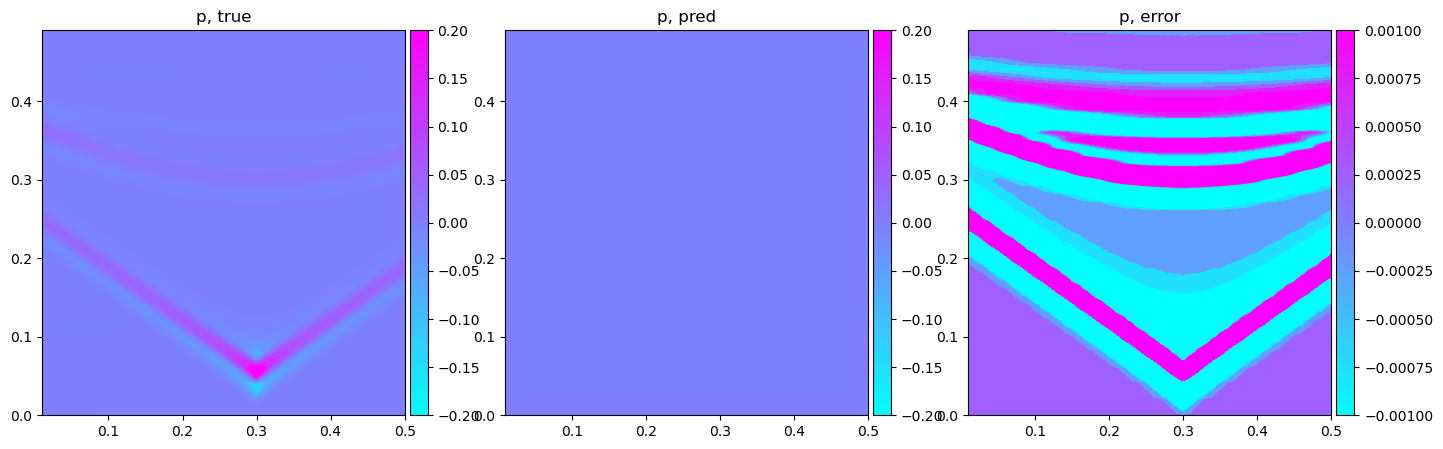

In [46]:
i = 5
p = loadmat("data/sr_{}.mat".format(int(x_s[i]*x0/dx)))["sr_{}".format(int(x_s[i]*x0/dx))]

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

x_test = np.linspace(10.0, 500.0, 50) / x0
z_test = np.array([10]) / z0
t_test = np.linspace(0.0, 0.49, 50) / t0
xzt_test = tensor_grid([t_test, x_test, z_test])
xzt_test[:, [0, 1, 2]] = xzt_test[:, [1, 2, 0]]

xzts = np.hstack([xzt_test, x_s[i]*np.ones_like(xzt_test[:, 0:1])])
out = direct_model(tf.constant(xzts, dtype = tf.float32))

cmap = cool
norm = Normalize(vmin=-0.2, vmax=0.2)

X, T = np.meshgrid(x_test, t_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, T, p, cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("p, true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = Normalize(vmin=-0.2, vmax=0.2)
im1 = ax[1].contourf(X, T, out[:, 0:1].numpy().reshape((len(t_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("p, pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-3, vmax=1e-3)
im2 = ax[2].contourf(X, T, p-out[:, 0:1].numpy().reshape((len(t_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[2].set_title("p, error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

In [49]:
np.min(out)

-3.430678e-05

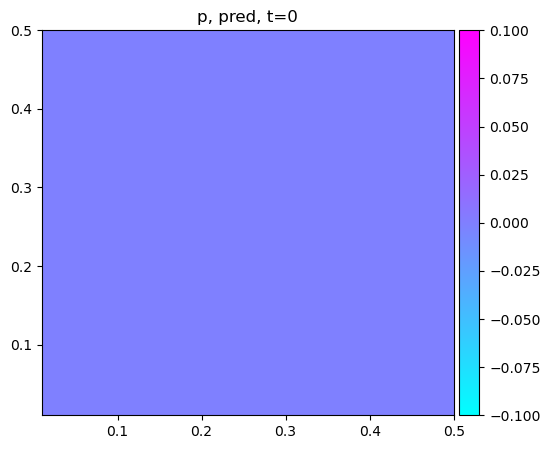

In [45]:
i = 0

x_test = np.linspace(10.0, 500.0, 50) / x0
z_test = np.linspace(10.0, 500.0, 50) / z0
t_test = np.array([0]) / t0
xzt_test = tensor_grid([t_test, x_test, z_test])
xzt_test[:, [0, 1, 2]] = xzt_test[:, [1, 2, 0]]

xzts = np.hstack([xzt_test, x_s[i]*np.ones_like(xzt_test[:, 0:1])])
out = direct_model(tf.constant(xzts, dtype = tf.float32))

cmap = cool
norm = Normalize(vmin=-0.1, vmax=0.1)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax.contourf(X, Z, out[:, 0:1].numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax.set_title("p, pred, t=0")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()